# Лабораторная 4

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from examples.tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import activations
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, Concatenate
from tensorflow.keras import utils

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Shuffling C:\Users\admin\tensorflow_datasets\oxford_iiit_pet\incomplete.UA7892_4.0.0\oxford_iiit_pet-train.tfr…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\admin\tensorflow_datasets\oxford_iiit_pet\incomplete.UA7892_4.0.0\oxford_iiit_pet-test.tfre…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\admin\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [5]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

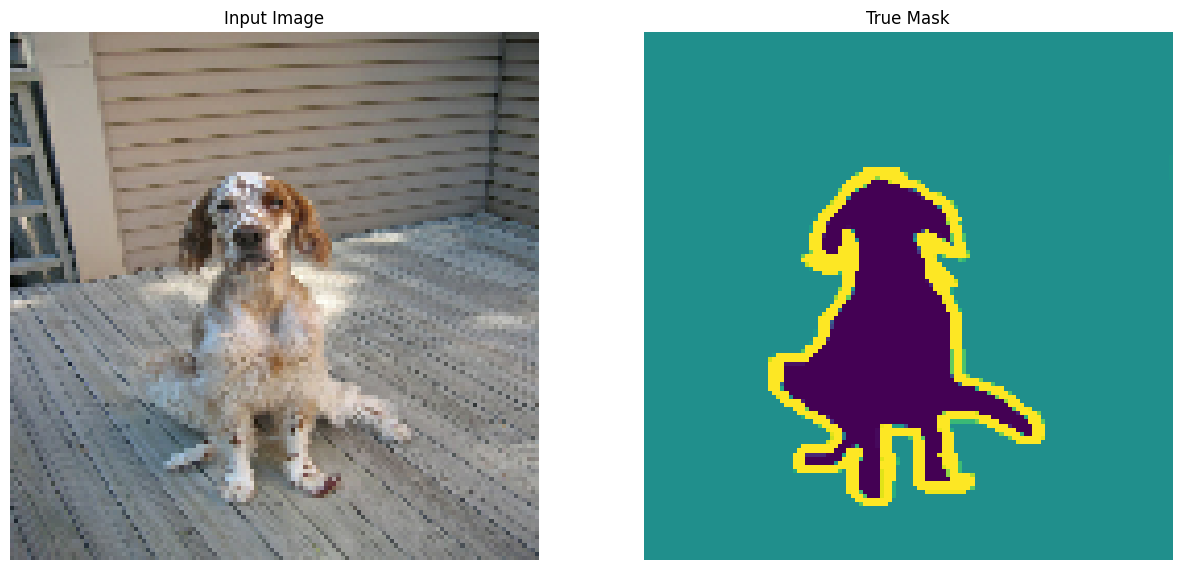

In [11]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [12]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [13]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [14]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [15]:
def unet_model(output_channels):
    inputs = Input(shape=(128, 128, 3))
    
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    b = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    b = Dropout(0.3)(b)
    b = Conv2D(128, (3, 3), activation='relu', padding='same')(b)

    u1 = UpSampling2D((2, 2), interpolation='bilinear')(b)
    u1 = Concatenate()([u1, c3])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2), interpolation='bilinear')(c4)
    u2 = Concatenate()([u2, c2])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(c5)

    u3 = UpSampling2D((2, 2), interpolation='bilinear')(c5)
    u3 = Concatenate()([u3, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c6 = Conv2D(16, (3, 3), activation='relu', padding='same')(c6)

    outputs = Conv2D(output_channels, (1, 1), activation=None, padding='same')(c6)

    return Model(inputs=inputs, outputs=outputs)

In [16]:
OUTPUT_CLASSES = 3
model = unet_model(OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


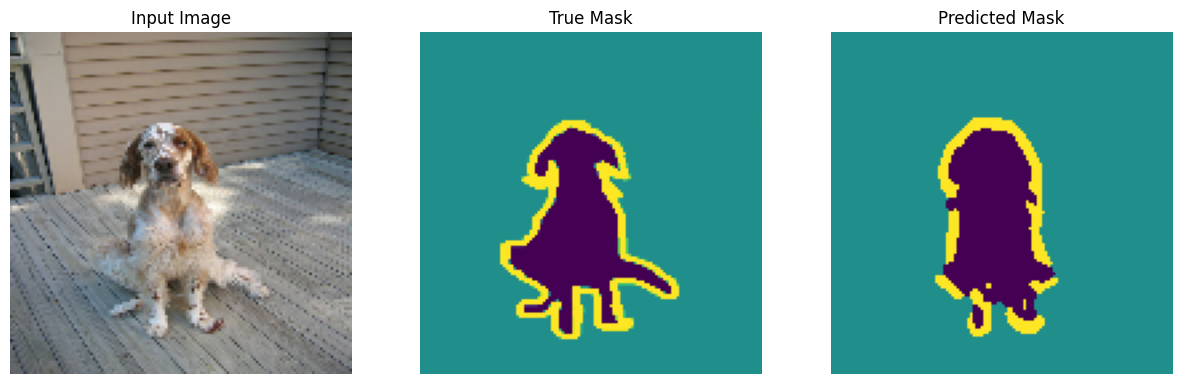


Sample Prediction after epoch 20

115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 398ms/step - accuracy: 0.8638 - loss: 0.3289 - val_accuracy: 0.8608 - val_loss: 0.3448


In [17]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    callbacks=[DisplayCallback()]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


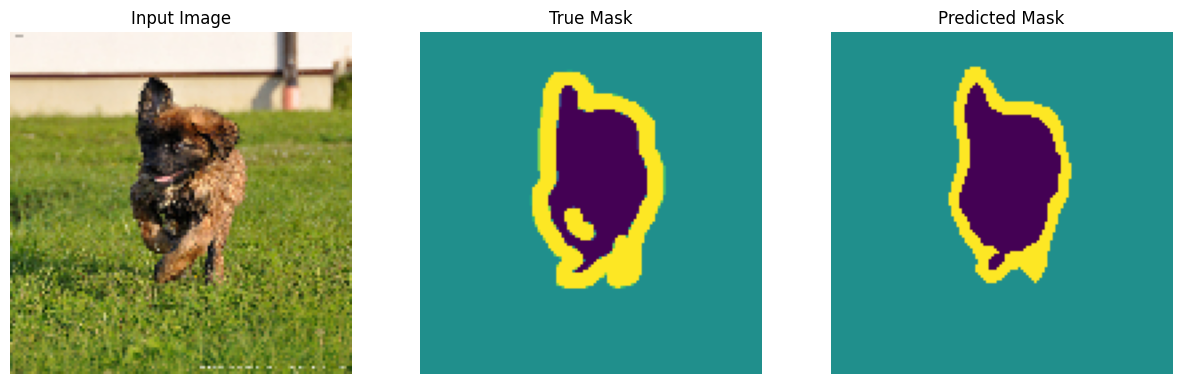

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


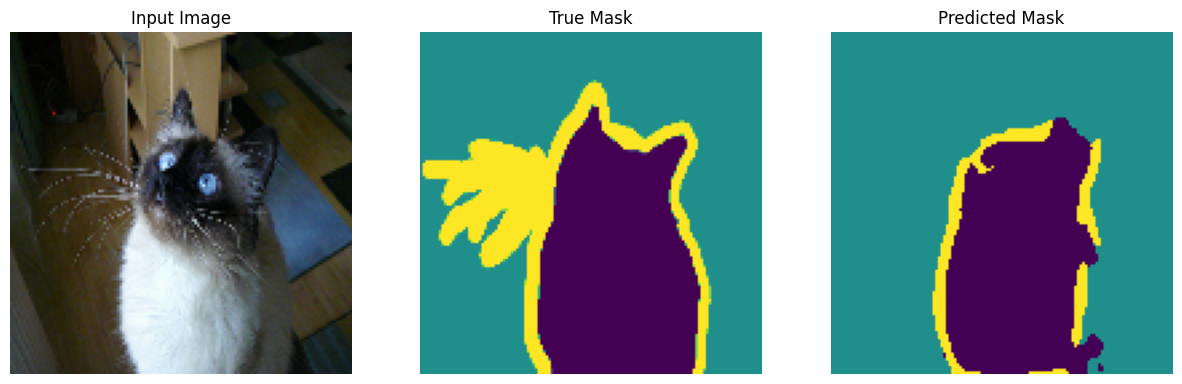

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


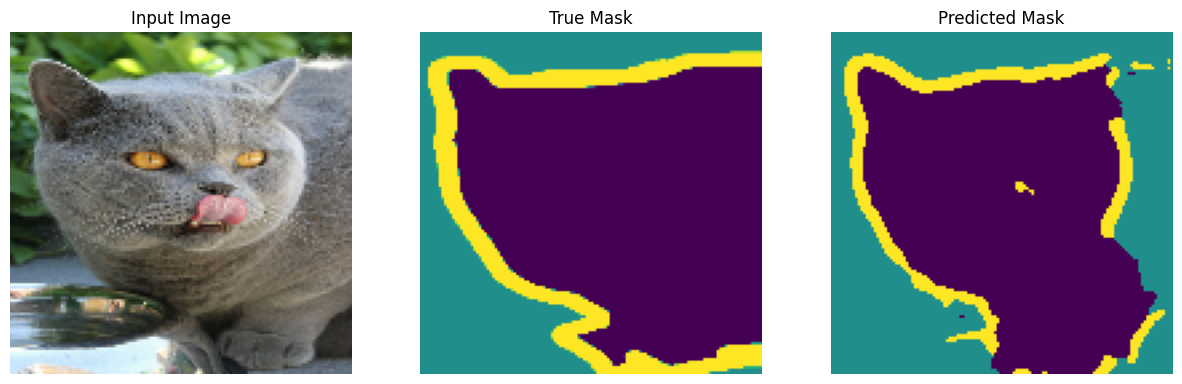

In [18]:
show_predictions(test_batches, 3)